# Federated learning monitoring

In [151]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
import json
import os
# set cwd
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/analysis")

In [152]:
fed_avg = glob.glob(f"../results_manual/**/federated_training/**/results.json", recursive=True)
# keep the one that has 15_rounds
fed_avg

['../results_manual/periodic/federated_training/FedODE/15_rounds/rep_1-alpha_0.5-lr_0.01-batchsize_32_clipping_True/federated_outputs/results.json',
 '../results_manual/periodic/federated_training/FedODE/15_rounds/rep_1-alpha_0.5-lr_0.01-batchsize_32_clipping_False/federated_outputs/results.json',
 '../results_manual/periodic/federated_training/FedAvg/15_rounds/rep_1-alpha_0.5-lr_0.01-batchsize_32_clipping_True/federated_outputs/results.json',
 '../results_manual/periodic/federated_training/FedAvg/15_rounds/rep_1-alpha_0.5-lr_0.01-batchsize_32_clipping_False/federated_outputs/results.json']

In [153]:
def read_loss_file(file):
    # Read the meta.csv file
    meta_file = file.replace("results.json", "meta.csv")
    meta_data = pd.read_csv(meta_file)
    lr = meta_data['lr'].item()
    batch_size = meta_data['batch_size'].item()
    clipping = meta_data['gradientclipping'].item()
    
    # Read the results.json file
    with open(file, 'r') as f:
        data = json.load(f)
    
    # Plot centralized evaluate
    df_centralized_evaluate = pd.DataFrame(data['centralized_evaluate'])
    df_federated_evaluate = pd.DataFrame(data['federated_evaluate'])
    # Add the learning rate to the DataFrame
    df_federated_evaluate['lr'] = lr
    df_centralized_evaluate['lr'] = lr
    # Add the batch size to the DataFrame
    df_federated_evaluate['batch_size'] = batch_size
    df_centralized_evaluate['batch_size'] = batch_size
    # Add the clipping to the DataFrame
    df_federated_evaluate['clipping'] = clipping
    df_centralized_evaluate['clipping'] = clipping

    # Aggregation column 
    # Check if file contins "FedAvg" in the path name
    if "FedAvg" in file:
        # if the path name contains "FedAvg" then add aggregation column "FedAvg"
        df_federated_evaluate['aggregation'] = "FedAvg"
        df_centralized_evaluate['aggregation'] = "FedAvg"
    else:
        # if the path name does not contain "FedAvg" then add aggregation column "FedProx"
        df_federated_evaluate['aggregation'] = "FedODE"
        df_centralized_evaluate['aggregation'] = "FedODE"


    # if the path name contains "FedAvg" then add aggregation column "FedAvg"

    # combine lr, batch size and clipping into one column
    df_federated_evaluate['hyperparameters'] = df_federated_evaluate.apply(lambda x: f"lr: {x['lr']}, batch_size: {x['batch_size']}, clipping: {x['clipping']}", axis=1)
    df_centralized_evaluate['hyperparameters'] = df_centralized_evaluate.apply(lambda x: f"lr: {x['lr']}, batch_size: {x['batch_size']}, clipping: {x['clipping']}", axis=1)
    
    df_federated_evaluate['type'] = "federated"
    df_centralized_evaluate['type'] = "centralized"

    # modify centralized_loss into loss
    df_centralized_evaluate.rename(columns={'centralized_loss': 'loss'}, inplace=True)
    # modify federated_loss into loss
    df_federated_evaluate.rename(columns={'federated_evaluate_loss': 'loss'}, inplace=True)

    return df_centralized_evaluate, df_federated_evaluate

In [154]:
df_centralized_evaluate = pd.DataFrame()
df_federated_evaluate = pd.DataFrame()
for file in fed_avg:
    df_centralized_evaluate_temp, df_federated_evaluate_temp = read_loss_file(file)
    df_centralized_evaluate = pd.concat([df_centralized_evaluate, df_centralized_evaluate_temp])
    df_federated_evaluate = pd.concat([df_federated_evaluate, df_federated_evaluate_temp])
# plot the loss
# plot the loss by hyperparameters
# merge the two dataframes
# append dataframes
df = pd.concat([df_centralized_evaluate, df_federated_evaluate])
df

,round,loss,centralized_accuracy,lr,batch_size,clipping,aggregation,hyperparameters,type,federated_evaluate_accuracy
0,0,1200.956194,0.242023,0.01,32,True,FedODE,"lr: 0.01, batch_size: 32, clipping: True",centralized,NaN
1,1,380.238316,0.078365,0.01,32,True,FedODE,"lr: 0.01, batch_size: 32, clipping: True",centralized,NaN
2,2,345.030413,0.070026,0.01,32,True,FedODE,"lr: 0.01, batch_size: 32, clipping: True",centralized,NaN
3,3,414.678885,0.083736,0.01,32,True,FedODE,"lr: 0.01, batch_size: 32, clipping: True",centralized,NaN
4,4,328.301583,0.066225,0.01,32,True,FedODE,"lr: 0.01, batch_size: 32, clipping: True",centralized,NaN
...,...,...,...,...,...,...,...,...,...,...
10,11,668.438293,NaN,0.01,32,False,FedAvg,"lr: 0.01, batch_size: 32, clipping: False",federated,0.134158
11,12,656.752177,NaN,0.01,32,False,FedAvg,"lr: 0.01, batch_size: 32, clipping: False",federated,0.132232
12,13,656.186056,NaN,0.01,32,False,FedAvg,"lr: 0.01, batch_size: 32, clipping: False",federated,0.131775
13,14,660.881877,NaN,0.01,32,False,FedAvg,"lr: 0.01, batch_size: 32, clipping: False",federated,0.132512


In [155]:
# extract lr 0.01 batch size 32 clipping True 
df_test = df[df['hyperparameters'] == "lr: 0.01, batch_size: 32, clipping: True"]


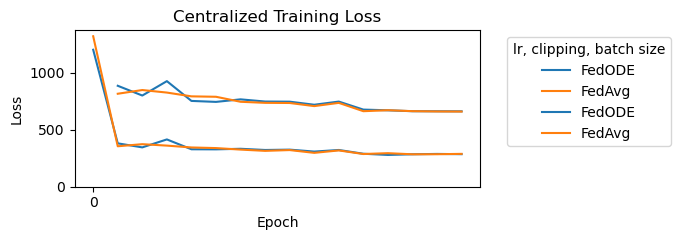

In [150]:
plt.figure(figsize=(5, 2.5))
sns.lineplot(
    data=df_test[df_test['type'] == "federated"],
    x='round',
    y='loss',
    hue='aggregation',  # Automatically creates different colors
    palette='tab10'  # Optional: choose color palette
)

sns.lineplot(
    data=df_test[df_test['type'] == "centralized"],
    x='round',
    y='loss',
    hue='aggregation',  # Automatically creates different colors
    palette='tab10'  # Optional: choose color palette
)

plt.ylim(bottom=0)
plt.xticks(ticks=range(0, df_federated_evaluate['round'].max() + 1, 25))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Centralized Training Loss')
plt.tight_layout()
# log y
# legend outside
plt.legend(title = "lr, clipping, batch size", bbox_to_anchor=(1.05, 1), loc='upper left')
# x log
plt.show()

In [121]:
for file in fed_avg:
    # Read the loss file
    df_centralized_evaluate, df_federated_evaluate = read_loss_file(file)

    # Plot the results
    plt.figure(figsize=(5, 3))
    sns.lineplot(data=df_centralized_evaluate, x='round', y='centralized_loss', label='Centralized Training')
    sns.lineplot(data=df_federated_evaluate, x='round', y='federated_evaluate_loss', label='Federated Training')
    
    # Set the title and labels
    plt.title(f"Loss vs Round (lr={df_federated_evaluate['lr'].unique()[0]})")
    plt.xlabel('Round')
    plt.ylabel('Loss')
    
    # Show the legend
    plt.legend()
    # legend outside of the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # Show the plot
    plt.show()

ValueError: Could not interpret value `centralized_loss` for `y`. An entry with this name does not appear in `data`.

<Figure size 500x300 with 0 Axes>

In [120]:
df_centralized_evaluate

,round,loss,centralized_accuracy,lr,batch_size,clipping,hyperparameters,type
0,0,1319.234096,0.267667,0.01,32,True,"lr: 0.01, batch_size: 32, clipping: True",centralized
1,1,354.763114,0.071396,0.01,32,True,"lr: 0.01, batch_size: 32, clipping: True",centralized
2,2,372.990165,0.077256,0.01,32,True,"lr: 0.01, batch_size: 32, clipping: True",centralized
3,3,360.498605,0.072760,0.01,32,True,"lr: 0.01, batch_size: 32, clipping: True",centralized
4,4,344.230190,0.069116,0.01,32,True,"lr: 0.01, batch_size: 32, clipping: True",centralized
5,5,338.811768,0.069285,0.01,32,True,"lr: 0.01, batch_size: 32, clipping: True",centralized
6,6,325.608538,0.065431,0.01,32,True,"lr: 0.01, batch_size: 32, clipping: True",centralized
7,7,314.499302,0.063677,0.01,32,True,"lr: 0.01, batch_size: 32, clipping: True",centralized
8,8,321.373989,0.064701,0.01,32,True,"lr: 0.01, batch_size: 32, clipping: True",centralized
9,9,297.027972,0.060099,0.01,32,True,"lr: 0.01, batch_size: 32, clipping: True",centralized


In [55]:
# Now load the federated learning loss
with open(fed_avg, 'r') as f:
    data = json.load(f)

# Plot centralized evaluate
df_centralized_evaluate = pd.DataFrame(data['centralized_evaluate'])
df_federated_evaluate = pd.DataFrame(data['federated_evaluate'])

# Join the two dataframes on the round
df_centralized_evaluate['round'] = df_centralized_evaluate['round'].astype(int)
df_federated_evaluate['round'] = df_federated_evaluate['round'].astype(int)

# join the two dataframes on the round
df = pd.merge(df_centralized_evaluate, df_federated_evaluate, on='round')
# now plot the data
plt.figure(figsize=(5, 2.5))
plt.plot(df['round'], df['centralized_loss'], label='Centralized Test Loss', color='blue')
plt.plot(df['round'], df['federated_evaluate_loss'], label='Federated Test Loss', color='orange')
# log scale

# add legend on the outside
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(bottom=0)
# x axis is discrete
plt.xticks(df['round'])

TypeError: unhashable type: 'list'

# Zoom in into the clients

In [ ]:
def plot_client_loss(file):

    # Load JSON file
    with open(file, "r") as f:
        data = json.load(f)


    # Extract loss values, rounds, and epochs
    loss_values = []
    rounds = []
    epochs = []

    epoch_count = 0  # To keep track of epochs

    for entry in data["client_train"]:
        round_number = entry["round"]
        for loss in entry["loss"]:
            rounds.append(round_number)
            loss_values.append(loss)
            epochs.append(epoch_count)
            epoch_count += 1

    # make it smaller 
    plt.figure(figsize=(10, 2.5))
    # Plot loss values sequentially across rounds and epochs
    plt.plot(epochs, loss_values, marker='o', label="Loss across epochs")


    # Add vertical lines for each round number
    for round_number in set(rounds):
        round_epochs = [i for i, r in enumerate(rounds) if r == round_number]
        if round_epochs:
            # Place a vertical line at the first epoch of each round
            # if it is not the first round
            if round_number != 0:
                plt.axvline(x=round_epochs[0], color='grey', linestyle='--', label=f"Round {round_number}")

    # Customize x-axis ticks to represent rounds
    xticks = [i for i, round_number in enumerate(rounds) if i == 0 or rounds[i] != rounds[i-1]]
    plt.xticks(xticks, [rounds[i] for i in xticks])
    # log scale y 
    plt.yscale('log')

    plt.ylim(bottom=0)
    plt.xlabel("Round")
    plt.ylabel("Local Loss (log scale)")
    plt.tight_layout()
    plt.show()


In [68]:
files = [f.replace("results.json", "") for f in fed_avg]
files = [f + "results_*.json" for f in files]
files = [glob.glob(f, recursive=True) for f in files]
files

[['../results/periodic/federated_training/FedAvg/15_rounds/rep_1-alpha_0.5-lr_0.01-batchsize_32/federated_outputs/results_0.json',
  '../results/periodic/federated_training/FedAvg/15_rounds/rep_1-alpha_0.5-lr_0.01-batchsize_32/federated_outputs/results_1.json']]